<a href="https://colab.research.google.com/github/DuncanFerguson/GITHUB_REPOSITORY/blob/main/Project_3_Duncan_Ferguson_Venice_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Statements

In [1]:
# Placing in the imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
import pathlib
from pathlib import Path

from IPython.display import Image
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
print('TensorFlow version:', tf.__version__)
import struct

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

!pip install ignite

# from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
# from ignite.metrics import Accuracy, Loss
 
np.set_printoptions(precision=3)

TensorFlow version: 2.8.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Objectives: Neural Network Training with TensorFlow
- 1). Read in a classifiable set of images from the internet using python, and transform those images into training, test, and validation TensorFlow Datasets that can be used for DNN training
- 2). Understand the ethical implication of the dataset I've identified, both in terms of the legality of its use and in regards to any inherent biases present in the training data.
- 3). Preprocess the training dataset to ensure images are on the same scale, and that the dimensionality of the data is correct for DNN training.
- 4). Use the TensorFlow Keras API to create a customer feedforward NN model with many layers that will be compiled and trained to classify my image data
- 5). Choose customer activation functions, layer parameters, layer regularization parameters, optimizers, loss functions, and performance metrics for my custom NN model
- 6). Create a Keras Estimator for my customer Keras model and use it to train my model and asses its performance
- 7). Visualize my estimator's training performance and decision boundary using MLxtend

# 1). Experiment Objective

### Objective: Describe the dataset I am analyzing, including the TOS and ethical considerations discussed in Lecture 7 & 8. 

- The data set that I chose to analyize was the dog breeds from Stanford.
- http://vision.stanford.edu/aditya86/ImageNetDogs/

- Dataset Reference
  - Primary:
  
    Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao and Li Fei-Fei. Novel dataset for Fine-Grained Image Categorization. First Workshop on Fine-Grained Visual Categorization (FGVC), IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2011.  [pdf]  [poster]  [BibTex]

  - Secondary:

    J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li and L. Fei-Fei, ImageNet: A Large-Scale Hierarchical Image Database. IEEE Computer Vision and Pattern Recognition (CVPR), 2009.  [pdf]  [BibTex]

- The terms of service allow anyone to use the data set for machine learning models. This is one of the main reasons I chose this dataset. It was ready to go, and it had dog breeds. I eventually want to design a dog door to use a camera to only let my dog in. Also, just a general interest in dogs.

### Objective: Why did I choose the training examples I did for training my model?

 - When choosing the training examples I took random portions from each dog breed to try and train the model. At first the modle was only trained with 1k photos. This was then expanded to include the whole data set. Mainly, I chose this data set because it was clean and I have an interest in create a dog door that uses machine learning to identify the homeowners god and lets them into the house. I also want to see if the algorithm that I write will be able to pick up on the pictures of my person dogs. 

### Objective: How are the images classified? 

- The images come with labels then the dog breeds. There was a little bit of file name manipulation to extract the dog breed, but otherwise it was readyto come off the shelf. BY manipulation I mean just string manipulation to extract the breed name. And add it as another column


### Objective Note: For this step do not use any of the datasets in the tensorflor_datasets library.

- The Data set came from Stanford website, It is not coming from the tensor flow library

# 2). Data Collection and Preprocessing

### Objective:  Am I accessing an API? Scaping a website? Downloading an archive?

- The data is being sorced from a Stanford Archive. The Dataset Reference is above. The files are kept in the images folder. There is additional data that I have included in the Ullr_Lou folder that includes personal pictures of my own dogs. I had to go through and classify these myself. 

### Objective: Write the necessary Python Code to retrieve and store the training examples to be used in the model

In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('content/',force_remount=True)
os.getcwd()

Mounted at content/


'/content'

In [3]:
# Going to the right directory
# Going to the right fold to unzip the images. Learned this the hard way
%cd content/MyDrive/ML_Colab/Project_3/Images

/content/content/MyDrive/ML_Colab/Project_3/Images


In [4]:
# Code to extract the files
# Downloading the images 
# !wget 'images' 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
# !tar -xf ./images.tar &>/dev/null

In [5]:
# Establishing the path to the pictures
root_dir = pathlib.Path("./Images")

In [6]:
# Creating a data frame of the images
root_dir = Path("./Images")  # path to dataset root directory

# Create a map from directory name to label index
image_dir = {n.name: i for i, n in enumerate(sorted(root_dir.iterdir()))}
image_dir
fpaths = []
labels = []
for d in root_dir.iterdir():
    for f in d.iterdir():
        labels.append(image_dir[d.name])
        fpaths.append(str(f))

df = pd.DataFrame(data={"fpath": fpaths, "label": labels})
df.head()

,fpath,label
0,Images/n02085620-Chihuahua/n02085620_10621.jpg,0
1,Images/n02085620-Chihuahua/n02085620_10976.jpg,0
2,Images/n02085620-Chihuahua/n02085620_11238.jpg,0
3,Images/n02085620-Chihuahua/n02085620_11258.jpg,0
4,Images/n02085620-Chihuahua/n02085620_1152.jpg,0


In [7]:
# Displaying that the labels are as big as the file path
display(len(labels))
display(len(fpaths))

20580

20580

In [8]:
# Cleaining up the file path and extracting the breed
breed_long_list = []
# # Finding the back space
for row in enumerate(df['fpath']):
  breed = df.iloc[row[0]]['fpath'][df.iloc[row[0]]['fpath'].rfind("-")+1:df.iloc[row[0]]['fpath'].rfind("/"):]
  breed_long_list.append(breed)

df['breed'] = breed_long_list

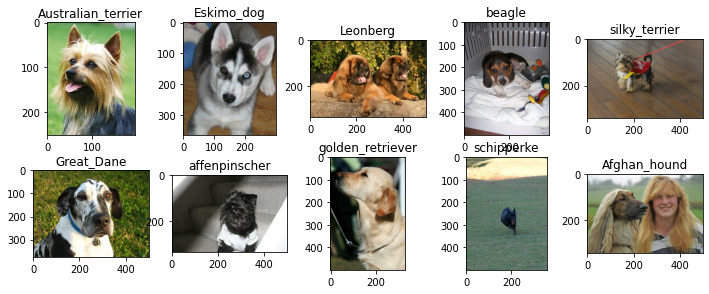

<Figure size 432x288 with 0 Axes>

In [9]:
# Creating Function to look images
def show_images(fpath, label):
  """This function takes in a file path the label
   - Preferaby the breed and the number of photos that we want to show"""
  plt.figure(figsize=(12,12))
  for i in range(len(fpath)):
    ax = plt.subplot(5, 5, i +1)
    img_raw = tf.io.read_file(fpath.iloc[i])
    img = tf.image.decode_image(img_raw)
    plt.imshow(img)
    plt.title(label.iloc[i])
  plt.show()
  plt.tight_layout()

sample = df.sample(10)
show_images(sample['fpath'], sample['breed'])

In [10]:
# Creating a function to process the photos
def process_and_shape(fpath):
  """This function goes through and processes the image.
  It is also reshepping the image. Vary similiar to above
  but there is no showing of the images. This function
  only returns the image"""
  img = tf.io.read_file(fpath)
  img = tf.image.decode_jpeg(img, channels=3)  # Note that the channels are set to three for the color
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, size=(250,250))
  return img

def image_and_label(fpath, label):
  """This function returns both the file and
  the image"""
  img = process_and_shape(fpath)
  return img, label


In [11]:
# Dataframe slicor for testing
import random
random.seed(42)
df = df.sample(1000)

In [12]:
# Tensors are being created here from the training and test sets.
# These create training sets send the tensors off to load and preprocess

def create_train_batch(x, y, b_size=32):
  """Creating Batches for the training set"""
  display("Training Batches Being Created")
  tf_train = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))

  # Shuffling the training model
  tf_train = tf_train.shuffle(buffer_size=len(x))
  train_batch = tf_train.map(image_and_label).batch(b_size)
  return train_batch

In [13]:
def create_test_batch(x, y, b_size=32):
  """Creating Batches for the training set
  Essentially the same as above but with out the shuffle"""
  display("Test Batches Being Created")
  tf_test = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
  test_batch = tf_test.map(image_and_label).batch(b_size)
  return test_batch

In [14]:
labels = df['label'].to_list()

# Casting Y to categorical variables
unique_labels = df['label'].unique()
y_cats = to_categorical(labels, num_classes=len(unique_labels), dtype='float32')

In [15]:
y_cats

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
# Showing how to get back the one hot encoding of the labels
y_labs = tf.math.argmax(input=y_cats)
y_labs

<tf.Tensor: shape=(120,), dtype=int64, numpy=
array([  8,  70, 146,  20, 177,   2, 115,   7,  12, 157,   5, 169, 351,
        16, 204,  72, 176,   4, 113,  32, 219,  94,  22,  36,  73,   1,
       111,  44, 112,  47,  64,  17, 203, 106, 338,  39,  14,  66, 189,
        86,  88,  23,  21,  18,  46, 428,  49, 411,  19,  56, 381,  29,
       158,  80,  62, 191,  77, 250, 150,  15, 216, 107,  41, 119, 155,
       198,  83, 233,  30,  69, 492,  91,  43,  82, 101,  58,  33, 314,
       356,  31,  38, 131, 253,  10, 347,  71,   3,   6, 120,  93, 171,
       207, 199,  99,  76,  74,  13, 164, 132,  68,  42,  60,  84, 294,
         9,  52,  28, 175, 102, 117,  59,  26, 105,  24,   0,  98,  37,
       160,  11, 114])>

In [17]:
# Dividing up the data into a training and test set
x_train, x_test, y_train, y_test = train_test_split(df['fpath'], y_cats, random_state=42, test_size=0.2)
x_train, x_test = x_train.to_numpy(), x_test.to_numpy()
# y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

display('X_train has a size of {} and a data format {}'.format(len(x_train), type(x_train)))
display('X_test has a size of {} and a data format {}'.format(len(x_test), type(x_test)))
display('y_train has a size of {} and a data format {}'.format(len(y_train), type(y_train)))
display('y_test has a size of {} and a data format {}'.format(len(y_test), type(y_test)))

"X_train has a size of 800 and a data format <class 'numpy.ndarray'>"

"X_test has a size of 200 and a data format <class 'numpy.ndarray'>"

"y_train has a size of 800 and a data format <class 'numpy.ndarray'>"

"y_test has a size of 200 and a data format <class 'numpy.ndarray'>"

In [18]:
# Sending off the training and test set for batching
train_batch = create_train_batch(x=x_train, y=y_train)

'Training Batches Being Created'

In [19]:
# Sending off the testing set]
test_batch = create_test_batch(x_test, y_test)

'Test Batches Being Created'

# 3). TensorFlow Model Creation

- Create a customer TensorFlow DNN Model using the Keras API, similiar to the 'Simplifying implementations of common architectures via the Keras API 'section of the chapter 14_part 1 exam.

- Should include at least two hidden layers

- Define appropriate feature columns for the input to th emodel base on the geature data that you extracted in the second quetion

- Keras Initializers
- Keras regularizers
- Activations
- Keras Optimizers
- Keras loss Function
- Keras Metrics 

In [20]:
shape_in = [None, 120, 120, 3] # Batch, hieght, weights, channels
shape_out = len(df['label'].unique())


def make_model(in_shape=shape_in, out_shape=shape_out):
  """This function contains the meat of the project.
   This is where we add in the different layers. Right now softmax is being nuse to deal with the categorical variables"""
      # Setup the model layers
  model = tf.keras.Sequential([tf.keras.layers.Dense(units=shape_out,
                              activation="softmax")])
  
  model.compute_output_shape(input_shape=shape_in)
  
  
  model.add(tf.keras.layers.GlobalAveragePooling2D())
  model.compute_output_shape(input_shape=shape_in)
  # Compile the model


  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
  model.build(shape_in)


  return model

## compile:
model = make_model()
display(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120, 120, 120)     480       
                                                                 
 global_average_pooling2d (G  (None, 120)              0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 480
Trainable params: 480
Non-trainable params: 0
_________________________________________________________________


None

In [21]:
## printing variables of the model
for v in model.variables:
    print('{:20s}'.format(v.name), v.trainable, v.shape)

dense/kernel:0       True (3, 120)
dense/bias:0         True (120,)


In [22]:
train_batch.element_spec

(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))

## Objective: Describe my choices and what affects each option has on my DNN model. 

- Describe why i chose the width and depth that I did for the NN Model.

The width and the depth of this model were chosen for the amount of the resized pixels. The Chanels helpd give the depth of 3 for three color channels coming through.

# 4). TensorFlow Estimator Creation and Training

- Take the compiled model from section 3 and use it to create a custom Keras Estimator
- Once the estimator is created, train it against the training data from part 2

In [23]:
hist = model.fit(x=train_batch, validation_data=test_batch, epochs=1, batch_size=32, verbose=True)

25/25 [==============================] - 126s 5s/step - loss: 4.7945 - accuracy: 0.0050 - val_loss: 4.8005 - val_accuracy: 0.0150


In [46]:
# Converting the one hot encoding back for the training set
y_train_labs = tf.math.argmax(input=y_train, axis=-1)
y_train_labs

<tf.Tensor: shape=(800,), dtype=int64, numpy=
array([ 51,  25,  55, 113,  74,  75,  98, 115,  74,  40,  25,   3,  80,
         5,  26,   6,   6,  61,  22,  38,  24,   4, 104,  46,   8,   5,
        80, 118,  52,  12,  46,   1,  29,  57,  76,  79, 101,  77,  21,
        97,  86,  14,  82,  21, 110, 108,  10,  56, 102,  62,  73,  16,
       115,   6, 115,  42,  23,  66, 100,  10,  51, 116,  44,  82,   0,
        17,  56,  80,  79,  50,  21, 106,   1,  57,  39, 104,  42,   1,
        35,  22,  92,  76, 102,  48,  58,  59,   3, 106,  48,  10,  74,
        58, 114,  16,  35,  71, 116,  45,   7,  64,   0,  97,  38,   2,
        10,  88, 118,  99,   8,  86, 110,  55,   6,  80,   3, 119,  51,
        58,  41,  80,  46,  80,  23,  48,  67,  76,  26, 118,   5,  83,
        89,  69,  26,  81, 114, 115,   2,  95, 113,  73,  35,  37, 113,
        68, 109, 115,  53, 116,  51, 118,  56,   1,  29,  69,  29,  81,
        59,  14,  80,  76,  37,  63,  35,  47,  97, 106,  12,  66,  44,
         7,  11,  

In [43]:
# Converting the testing back from one hot encoding
from tensorflow.python.ops.numpy_ops import np_config
y_test_labs = tf.math.argmax(input=y_test, axis=1)
y_test_labs

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([ 76,  46, 119,  49,  47, 107,  68, 117,   3,  62,  78,  94, 100,
        31, 109,  41,  11,  19,  55,  16,  16,  58,  41,  52,  23,   9,
        74,  15, 107,  89, 106,  30,   6,  33,   0,  65,  76, 109,  33,
       110, 110, 102,  28,  30,  30,  76,   5,  46,  60, 116,  93, 111,
        22,  24,  41,  68,  92,  83,  37,  92,  68, 116, 117, 119,   5,
       119,  14, 102,   1,  34,  61,  17,  32,  26,  29,   9,   7,  35,
        19,  79,  95,  37,  22,  54,  73,  28,  25,  57, 119,  16,  33,
        19, 104,   7,  50,  20, 100,  40, 105, 101,  27,  12,  92,  55,
        49,  58,  66, 106,  95, 112,   6,  52,  23,  52,  39, 106,  81,
        69,  58, 103,  54,  25, 105,   4, 102,  44,  59,  27,  60,  49,
        84,  28, 112,  86, 106, 111,  88,  10,   8,  15,  27,  83,  90,
       102,  23,   5,  64,  11,  89,  76,  49,  52,  72,  61,  63,  46,
        53,  20, 101, 111, 107,   4,  88,   0, 104, 112,  18,  81,  77,
       106,  58,  

In [44]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test_labs, batch_size=32)

Evaluate on test data


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


UnimplementedError: ignored

# 5). TensorFlow Estimator Performance Evaluation and Visualization

- Begin by visualizing the loss and the evaluation metric decided on in part three
- Do this by calling the fit method directly on the model and plutting the resulting history object
-
- Tak the Trained Estimator in part four and evaluate it against my validation data.
- After your model visualization and estimator evaluation is created; summarize the findings in a mark down cell
- Discuss the performance of the model, and the accuracy of the created decision boundary
- Did your model estimator work well?

In [ ]:
# Making predictions with our estimate and evaluating performance
predic = model.predict(test_batch, verbose=1)
predic

In [ ]:
from mlxtend.plotting import plot_decision_regions

history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
# plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=predic, y=y_test.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

In [ ]:
x_test